# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip list

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr
import matplotlib.pyplot as plt

C:\Users\SAM\AppData\Local\Temp\ipykernel_6640\2011824555.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
os.listdir(os.path.join(data_dir, 'happy'))

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image)

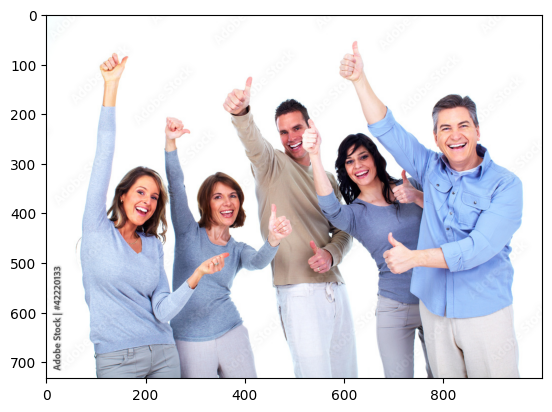

In [15]:
img = cv2.imread(os.path.join('data', 'happy', '1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg'))
type(img)
img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [16]:
# Loop over each class (subdirectory) in the main data directory
for image_class in os.listdir(data_dir): 

    # Loop over each image in the current class directory
    for image in os.listdir(os.path.join(data_dir, image_class)):

        # Create the full path to the current image
        image_path = os.path.join(data_dir, image_class, image)

        try: 
            # Read the image using OpenCV
            img = cv2.imread(image_path)

            # Check the image file type using imghdr
            tip = imghdr.what(image_path)

            # If the image file type is not in the expected extension list
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                # Uncomment the line below to remove the image with an invalid extension
                os.remove(image_path)

        except Exception as e: 
            # If there is an issue with reading the image, print an error message
            print('Issue with image {}'.format(image_path))

            # Uncomment the line below to remove the problematic image
            # os.remove(image_path)

# 3. Load Data

In [ ]:
# read more on this sammy
# tf.data.Dataset

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# tf.keras.utils.image_dataset_from_directory??

In [18]:
# Create an image dataset from a directory using the provided utility function
# The function automatically labels and preprocesses the images in the specified directory
data = tf.keras.utils.image_dataset_from_directory('data')  

Found 165 files belonging to 2 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
# images represented as numpy arrays
batch = data_iterator.next()

In [21]:
# class 1 = sad people
# class 0 = happy people
batch[1]

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1])

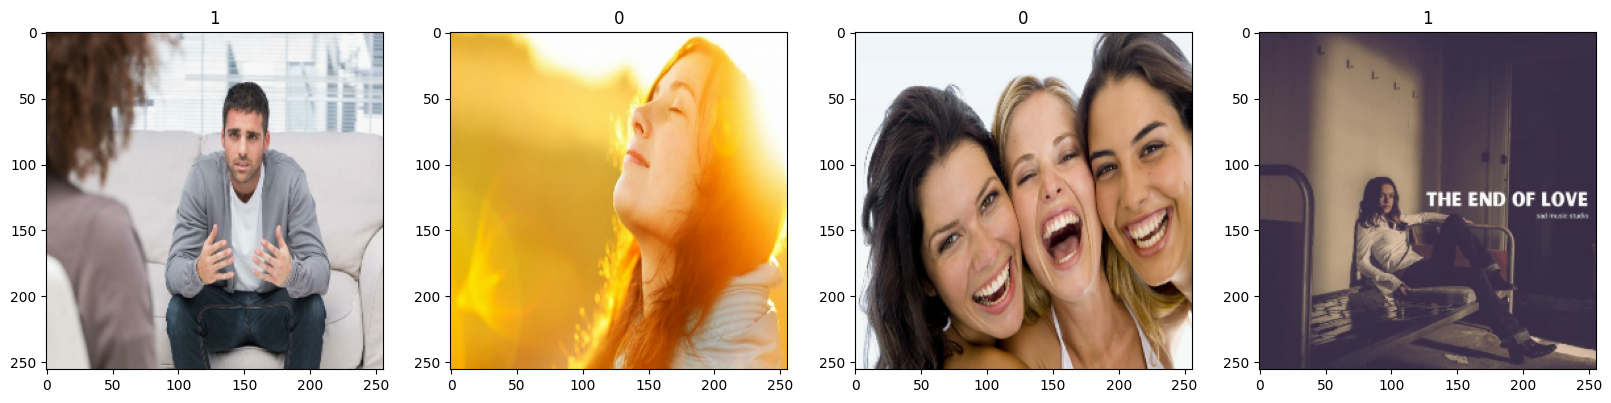

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [23]:
data = data.map(lambda x,y: (x/255, y))

In [24]:
data.as_numpy_iterator().next()[0].max()

1.0

# 5. Split Data

In [25]:
len(data)

6

In [26]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [27]:
train_size + val_size+test_size

6

In [111]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [114]:
model = Sequential() 

In [115]:
# First Convolutional Layer with MaxPooling
model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

# Second Convolutional Layer with MaxPooling
model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

# Third Convolutional Layer with MaxPooling
model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# First Dense (Fully Connected) Layer
model.add(Dense(256, activation='relu'))

# Output layer with Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [117]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 


 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 256)               3686656   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
          

# 7. Train

In [119]:
logdir='logs'

In [120]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [121]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


3/3 [==============================] - 35s 8s/step - loss: 0.9662 - accuracy: 0.5000 - val_loss: 0.9032 - val_accuracy: 0.5156
Epoch 2/20
3/3 [==============================] - 19s 6s/step - loss: 0.7849 - accuracy: 0.5208 - val_loss: 0.6426 - val_accuracy: 0.5469
Epoch 3/20
3/3 [==============================] - 14s 5s/step - loss: 0.6310 - accuracy: 0.5625 - val_loss: 0.6193 - val_accuracy: 0.5938
Epoch 4/20
3/3 [==============================] - 13s 4s/step - loss: 0.6046 - accuracy: 0.5833 - val_loss: 0.5483 - val_accuracy: 0.6094
Epoch 5/20
3/3 [==============================] - 15s 5s/step - loss: 0.6174 - accuracy: 0.5208 - val_loss: 0.5609 - val_accuracy: 0.6406
Epoch 6/20
3/3 [==============================] - 12s 4s/step - loss: 0.5801 - accuracy: 0.6667 - val_loss: 0.4957 - val_accuracy: 0.7812
Epoch 7/20
3/3 [==============================] - 12s 4s/step - loss: 0.4979 - accuracy: 0.8229 - val_loss: 0.6517 - val_accuracy: 0.5312
Epoch 8/20
3/3 [================

# 8. Plot Performance

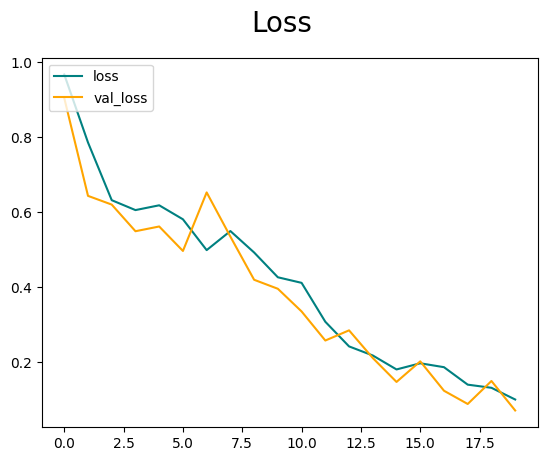

In [122]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

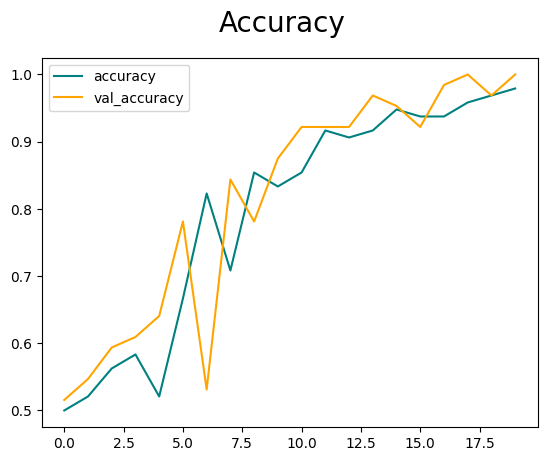

In [123]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [124]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [125]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [127]:
len(train)

3

In [215]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: data\sad\images2.jpg : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

In [130]:
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

Precision:1.0, Recall:1.0, Accuracy:1.0


# 10. Test

In [131]:
import cv2

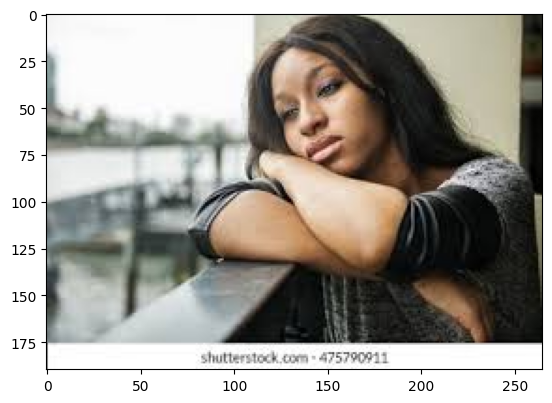

In [226]:
img = cv2.imread('images.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

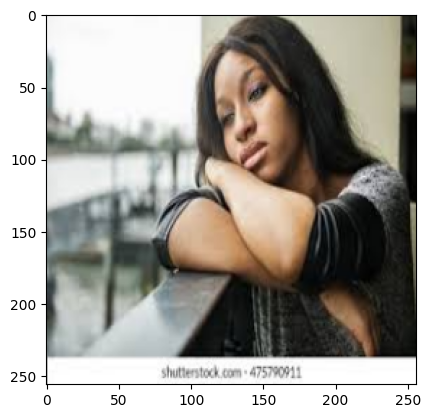

In [227]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(resize.numpy().astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()


In [202]:
np.expand_dims(resize, 0).shape


(1, 256, 256, 3)

In [230]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 258ms/step


In [231]:
yhat

array([[0.7637141]], dtype=float32)

In [232]:
if yhat > 0.5: 
    print(f'Anjola is Sad')
else:
    print(f'Anjola is Happy')

Anjola is Sad


# 11. Save the Model

In [217]:
from tensorflow.keras.models import load_model

In [207]:
model.save(os.path.join('models','happysadmodel.h5'))

In [219]:
new_model = load_model('models\imageclassifier2.h5')

In [228]:
sam = new_model.predict(np.expand_dims(resize/255, 0))
if sam > 0.5: 
    print(f'Anjola is Sad')
else:
    print(f'Anjola is Happy')

1/1 [==============================] - 0s 111ms/step
Anjola is Sad
